## Machine Learning

In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from tqdm import tqdm

from ghl.datasets.custom_dataset import CustomDataset

In [2]:
ds = CustomDataset("./tmp", dataset_name="enriched_openbiolink")
input_dir = Path("./4_outputs/standard/")
output_dir = Path("./5_outputs/standard/")

In [3]:
xy_dir = input_dir / "XY"
train_dir = xy_dir / "train"
val_dir = xy_dir / "val"
test_dir = xy_dir / "test"

y_train_file = train_dir / "y.csv"
y_val_file = val_dir / "y.csv"
y_test_file = test_dir / "y.csv"

X_train_files = [f for f in train_dir.glob("*.csv") if not f.name == "y.csv"]
X_val_files = [val_dir / f.name for f in X_train_files]
X_test_files = [test_dir / f.name for f in X_train_files]


def calc_metrics(y_pred, y_true):
    return {
        "f1": f1_score(y_pred=y_pred, y_true=y_true),
        "recall": recall_score(y_pred=y_pred, y_true=y_true),
        "precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
        "confusion_matrix": confusion_matrix(y_pred=y_pred, y_true=y_true),
    }


def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    metrics = calc_metrics(y_pred=y_pred, y_true=y)
    cm = metrics["confusion_matrix"]
    metrics["TP"] = cm[0, 0]
    metrics["FP"] = cm[0, 1]
    metrics["FN"] = cm[1, 0]
    metrics["TN"] = cm[1, 1]
    del metrics["confusion_matrix"]
    return metrics


def evaluate(m, X, y, n=100, scale=True):
    y_pred = m.predict(X) > 0
    y_prob_pred = m.predict_proba(X)

    order = np.argsort(y_prob_pred)[::-1]
    # print(y_pred[order][:n])
    if scale:
        return y[order][:n].sum() / y.sum()
    else:
        return y[order][:n].sum()


def fit_model(X_train, y_train, model, parameters, scoring=evaluate, cv=5, **kwargs):
    clf = GridSearchCV(model, parameters, scoring=scoring, cv=cv, **kwargs)
    clf.fit(X=X_train, y=y_train)
    return clf


CV = 5
N_JOBS = 20


def train_predictor(
    X_train_file,
    y_train_file,
    out_file,
    cv=CV,
    n_jobs=N_JOBS,
    scoring=evaluate,
):
    m = RandomForestClassifier()
    parameters = dict(
        n_estimators=[100, 250, 500],
        max_depth=[None, 2, 5, 10],
        min_samples_leaf=[1, 32, 128, 256],
        max_features=[
            "sqrt",
            1,
            2,
            4,
            8,
        ],
    )

    X_train = pd.read_csv(X_train_file, index_col=0).values
    y_train = pd.read_csv(y_train_file, index_col=0).iloc[:, 0].values

    clf = fit_model(
        X_train=X_train,
        y_train=y_train,
        model=m,
        parameters=parameters,
        cv=cv,
        n_jobs=n_jobs,
    )

    with open(out_file, "wb") as f:
        pickle.dump(clf, f)
    return clf

In [ ]:
classifiers_dir = output_dir / "classifiers_ml"
classifiers_dir.mkdir(exist_ok=True, parents=True)

rerun = False
for X_train_file in tqdm(X_train_files):
    nm = X_train_file.name.split(".")[0]
    out_file = classifiers_dir / f"{nm}.pkl"
    if out_file.exists():
        try:
            # try to load the file
            with open(out_file, "rb") as f:
                pickle.load(f)
            if not rerun:
                print(out_file, "exists. Skipping...")
                continue
        except:
            pass

    train_predictor(
        X_train_file=X_train_file,
        y_train_file=y_train_file,
        out_file=out_file,
        cv=CV,
        n_jobs=N_JOBS,
    )

  8%|▊         | 2/25 [27:49<5:56:44, 930.62s/it]

In [8]:
classifiers_dir = output_dir / "classifiers_ml"
classifier_paths = list(classifiers_dir.glob("*.pkl"))

probas = {}
val_results = {}
indices = {}
for clf_file in tqdm(classifier_paths):
    with open(clf_file, "rb") as f:
        clf = pickle.load(f)

    nm = clf_file.name.split(".")[0]
    for ds in ("train", "val", "test"):
        if probas.get(ds) is None:
            probas[ds] = {}
        X_file = xy_dir / ds / f"{nm}.csv"
        y_file = xy_dir / ds / "y.csv"

        X_df = pd.read_csv(X_file, index_col=0)
        indices[ds] = X_df.index
        X = X_df.values
        y = pd.read_csv(y_file, index_col=0).iloc[:, 0].values

        probas[ds][nm] = clf.predict_proba(X)
        if ds == "val":
            y_pred = clf.predict(X)
            val_results[nm] = calc_metrics(y_true=y, y_pred=y_pred)

100%|██████████| 25/25 [01:27<00:00,  3.52s/it]


In [9]:
train_probas_df = pd.DataFrame(
    {nm: v[:, 1] for nm, v in probas["train"].items()}, index=indices["train"]
)
val_probas_df = pd.DataFrame(
    {nm: v[:, 1] for nm, v in probas["val"].items()}, index=indices["val"]
)
test_probas_df = pd.DataFrame(
    {nm: v[:, 1] for nm, v in probas["test"].items()}, index=indices["test"]
)

train_probas_df.to_csv(output_dir / "train_probabilities.csv")
val_probas_df.to_csv(output_dir / "val_probabilities.csv")
test_probas_df.to_csv(output_dir / "test_probabilities.csv")

In [10]:
proba_dfs = {}
Xs = {}
y_dfs = {}
ys = {}
indices = {}
for ds in ("train", "val", "test"):
    proba_df = pd.read_csv(output_dir / f"{ds}_probabilities.csv", index_col=0)
    proba_dfs[ds] = proba_df
    y_df = pd.read_csv(xy_dir / f"{ds}/y.csv", index_col=0)
    y_dfs[ds] = y_df

    X = proba_df.values
    Xs[ds] = X
    y = y_df.iloc[:, 0].values
    ys[ds] = y

    indices[ds] = proba_df.index

# lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=(1), max_iter=10000, C=1.0)
lr = LogisticRegression(max_iter=1000)
lr.fit(Xs["train"], ys["train"])
lr.coef_

array([[1.20442563, 0.59525068, 1.19606507, 0.59904568, 1.18682471,
        1.15338959, 1.18140775, 1.19101712, 1.19788447, 0.27062127,
        0.59946042, 1.0943716 , 0.14633838, 0.70068013, 0.93938277,
        0.26905399, 0.26813874, 0.59924966, 0.99690657, 1.20619167,
        0.27177153, 1.20613937, 1.19690073, 0.27022555, 0.59790401]])

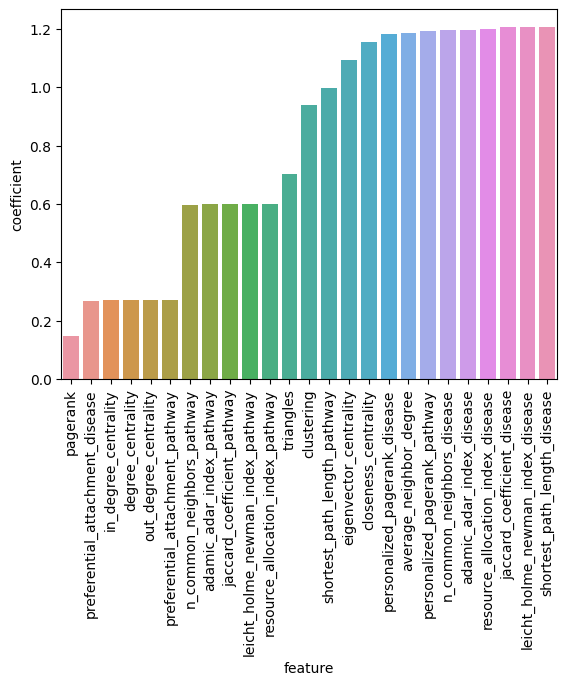

In [11]:
import seaborn as sns

plot_df = pd.DataFrame(
    {"feature": proba_dfs["train"].columns.values, "coefficient": lr.coef_[0]}
)
plot_df["coefficient_abs"] = plot_df["coefficient"].abs()

plot = sns.barplot(plot_df.sort_values("coefficient_abs"), x="feature", y="coefficient")
_ = plot.set_xticklabels(
    labels=plot.get_xticklabels(),
    rotation=90,
)

In [12]:
y_val_pred = lr.predict(Xs["val"])

calc_metrics(y_pred=y_val_pred, y_true=ys["val"])

{'f1': 0.5465116279069768,
 'recall': 0.376,
 'precision': 1.0,
 'confusion_matrix': array([[3796,    0],
        [  78,   47]])}

In [13]:
y_test_pred = lr.predict(Xs["test"])

metrics = calc_metrics(y_pred=y_test_pred, y_true=ys["test"])
metrics["confusion_matrix"]

array([[3796,    0],
       [  74,   45]])

In [14]:
y_test_prob = lr.predict_proba(Xs["test"])
y_test_pred = lr.predict(Xs["test"])

tmp_df = pd.DataFrame(y_test_prob, index=indices["test"])
tmp_df["irr"] = ys["test"]
tmp_df_sorted = tmp_df.sort_values(0, ascending=True)

In [15]:
((y_test_prob[:, 1] > 0.5) == y_test_pred).all()

True

In [16]:
ths = np.linspace(0.0, 1.0, 101)

ratios = []
for th in ths:
    idcs = tmp_df_sorted[1] >= th
    ratios.append(tmp_df_sorted[idcs]["irr"].sum() / tmp_df_sorted["irr"].sum())
ratios = np.array(ratios)

ratio_df = pd.DataFrame(dict(th=ths, ratio=ratios))

Text(0, 0.5, 'irr_pred / irr_total')

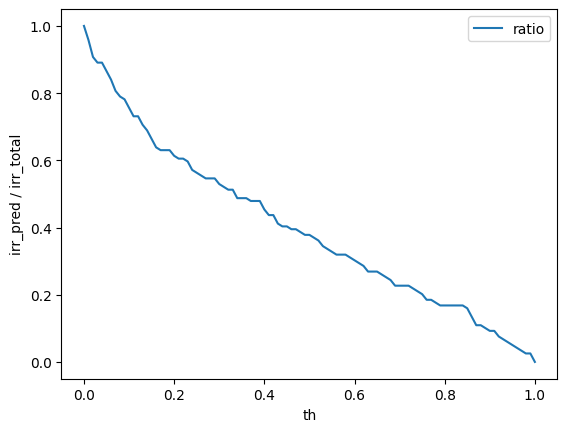

In [17]:
ratio_df.plot(x="th", y="ratio").set_ylabel("irr_pred / irr_total")

In [18]:
ys["test"].sum()

119

In [19]:
n_top = 100

tmp_df_sorted.iloc[:n_top]["irr"].sum()

93

In [21]:
n_top = 10

tmp_df_sorted.iloc[:n_top]["irr"].sum()

10

In [22]:
from ghl.datasets.openbiolink import OpenBioLinkDataset

ds = OpenBioLinkDataset("./tmp/openbiolink/")
nodes_df = ds.get_nodes()

proba_df_all = pd.concat(
    [
        proba_dfs["train"][~proba_dfs["train"].index.duplicated(keep="first")],
        proba_dfs["val"],
        proba_dfs["test"],
    ]
).sort_index()

y_df_all = pd.concat(
    [
        y_dfs["train"][~y_dfs["train"].index.duplicated(keep="first")],
        y_dfs["val"],
        y_dfs["test"],
    ]
).sort_index()

X_all = proba_df_all.values
y_all = y_df_all.values
y_pred_all = lr.predict_proba(X_all)
y_pred_all_df = pd.DataFrame(y_pred_all, index=proba_df_all.index).drop(0, axis=1)
y_pred_all_df.columns = ["probability"]

In [23]:
out_df = y_pred_all_df.join(nodes_df, how="left")
out_df = out_df.join(y_df_all)
out_df.sort_values("probability", ascending=False)

,probability,node_id,node_type,irr
113459,0.999963,NCBIGENE:4846,GENE,True
119101,0.999963,NCBIGENE:7852,GENE,True
107681,0.999963,NCBIGENE:207,GENE,True
107674,0.999963,NCBIGENE:2064,GENE,True
106358,0.999963,NCBIGENE:147,GENE,True
...,...,...,...,...
121665,0.000051,NCBIGENE:9074,GENE,False
121657,0.000051,NCBIGENE:9069,GENE,False
110694,0.000051,NCBIGENE:29964,GENE,False
121641,0.000051,NCBIGENE:90624,GENE,False


In [24]:
out_df.to_csv(output_dir / "proba_out_df.csv")